In [8]:
import pathlib
import sys

sys.path.append(pathlib.Path.cwd().parent.as_posix())
from src.data.preprocess.lib.utils import (
    blacklist_invalid_dicom,
    blacklist_mislabelled_roi,
    blacklist_multiple_image_id,
    blacklist_no_image,
    blacklist_pixel_overlap,
    get_patient_split,
)

## Selection

In [4]:
len(blacklist_invalid_dicom())

1

In [5]:
len(blacklist_pixel_overlap())

15

In [6]:
len(blacklist_no_image())

3

In [7]:
len(blacklist_multiple_image_id())

27

In [15]:
len(blacklist_mislabelled_roi())

2

## Flood Fill

In [23]:
import json

import matplotlib.pyplot as plt
import numpy as np

In [72]:
project_root_path = pathlib.Path.cwd().parent
clean_json_path = next(project_root_path.rglob("clean*.json"))

with clean_json_path.open(mode="r") as json_file:
    clean_json_dict = json.load(json_file)

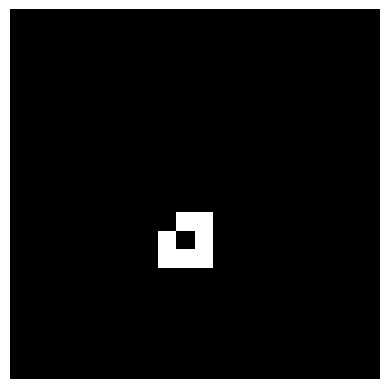

In [91]:
pos = clean_json_dict["001"][2]["roi"][0]["pos"]
temp = np.zeros((512, 512))
temp[tuple(zip(*pos))] = 1
temp = np.transpose(temp)
plt.axis("off")
# plt.imshow(temp[195:210,175:190],cmap="gray") # 0
# plt.imshow(temp[110:130,110:130],cmap="gray") # 1
plt.imshow(temp[130:150, 120:140], cmap="gray")  # 2

## Preprocessing

In [ ]:
import pydicom as pdc
import tensorflow as tf

In [ ]:
patient_idx = 0
patient_img_idx = 1

patient_root_path = next(project_root_path.rglob(f"patient/{patient_idx}"))
patient_img_path = list(
    patient_root_path.rglob(f"*00{str(patient_img_idx).zfill(2)}.dcm")
)[0]

dcm = pdc.dcmread(patient_img_path)
dcm_arr = dcm.pixel_array
dcm_hu = pdc.pixel_data_handlers.util.apply_modality_lut(dcm_arr, dcm)
dcm_clip = tf.clip_by_value(dcm_hu, -800, 1200)
dcm_norm = (dcm_clip - -800) / (1200 - -800)
dcm_zero = dcm_norm - tf.reduce_mean(dcm_norm)

fig, ax = plt.subplots(1, 5, figsize=(20, 100))

for i, (im_name, img) in enumerate(
    zip(
        [
            "Raw Image",
            "HU Image",
            "Clipped Image",
            "Normalized Image",
            "Zero Centered Image",
        ],
        [dcm_arr, dcm_hu, dcm_clip, dcm_norm, dcm_zero],
    )
):
    ax[i].set_title(im_name)
    ax[i].axis("off")
    img_ax = ax[i].imshow(img, cmap="gray")
    cax = fig.add_axes(
        [
            ax[i].get_position().x0,
            ax[i].get_position().y0 - 0.002,
            ax[i].get_position().width,
            0.001,
        ]
    )
    fig.colorbar(img_ax, cax=cax, orientation="horizontal")

## Random Oversampling

In [10]:
d = get_patient_split([0.7, 0.2, 0.01])

In [12]:
len(d["train"])

291

In [13]:
len(d["val"])

83

In [14]:
len(d["test"])

206